The assignment's goal is to create a generative replay method for continual learning. Youcan either implement the method from scratch or modify the code developed during the 3rdlab session. 

We recommend using either GANs [1] or VAEs [2] for the generative model.
However, other generative approaches are also acceptable.
You should evaluate the method in the class-incremental scenario with five splits of twoclasses each. We recommend using Fashion-MNIST or CIFAR-10 datasets due to thecomputational considerations. 

You should evaluate the method's effectiveness using the average accuracy, forward transfer, and backward transfer metrics. You can find theimplementation of these metrics in code from the 1st lab session. Additionally, the memoryand computational complexity of the method should be analyzed and included in the collabenvironment. For more details about metrics, see slides 41-46. Please include the paragraphdescribing the choice of hyperparameters such as learning rate, number of generatedsamples, or training epochs.[1]https://arxiv.org/abs/1406.2661
[2]https://arxiv.org/abs/1312.6114


I will be implementing generative replay inspired by one in following article https://www.nature.com/articles/s41467-020-17866-2#code-availability. 

https://paperswithcode.com/paper/continual-learning-with-deep-generative



# Imports

In [ ]:
! pip install torchgan

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Subset, TensorDataset, DataLoader
from random import shuffle
import random

import torchgan
from torchgan.models import DCGANGenerator, DCGANDiscriminator
from torchgan.losses import MinimaxGeneratorLoss, MinimaxDiscriminatorLoss
from torchgan.trainer import Trainer

if not torch.cuda.is_available():
    raise SystemError("GPU device not found, selection Runtime -> Change runtime type")

In [10]:
# Set random seed for reproducibility
manualSeed = 23
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)

Random Seed:  23


# Dataset

In [17]:
def get_dataset(dataroot, dataset):
    if dataset == 'FashionMNIST':
        mean, std = (0.5), (0.5)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std), torchvision.transforms.Resize(32)])
    
    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )
    
    return train_dataset, val_dataset

lsgan_losses = [LeastSquaresGeneratorLoss(), LeastSquaresDiscriminatorLoss()] 
def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

In [325]:
train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])

In [10]:
img = next(iter(train))

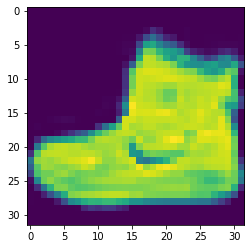

In [11]:
plt.imshow(img[0][0])

# Experiment tracking setup

In [ ]:
#! pip install clearml

In [50]:
#@title Insert your own Credentials

from clearml import Task

web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = ''#@param {type:"string"}
secret_key = ''#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

# Metrics and plotting

In [20]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt


# GANs

In [ ]:
!pip install torchgan

In [19]:
import torchgan
from torchgan.models import DCGANGenerator, DCGANDiscriminator
from torchgan.losses import MinimaxGeneratorLoss, MinimaxDiscriminatorLoss, LeastSquaresGeneratorLoss, LeastSquaresDiscriminatorLoss
from torchgan.trainer import Trainer
import torch.nn as nn

In [36]:
def train_DCGAN(data, task_classes, args):
    gan_split = {str(i): classi for i, classi in enumerate(task_classes)}  #e.g. class_split['0'] == task classes
    gan_tasks = split_dataset(data, gan_split)
    gans = {}
    for key, subtask in gan_tasks.items():
        loader = DataLoader(subtask, batch_size=args['bs'], shuffle=True)
        dcgan_network = {
            "generator": {
                "name": DCGANGenerator,
                "args": {
                    "encoding_dims": 100,
                    "out_channels": 1,
                    "step_channels": args['gan_step_channels'],
                    "nonlinearity": nn.LeakyReLU(0.2),
                    "last_nonlinearity": nn.Tanh(),
                },
                "optimizer": {"name": torch.optim.Adam, "args": {"lr": args['gen_lr'], "betas": (0.5, 0.999)}},
            },
            "discriminator": {
                "name": DCGANDiscriminator,
                "args": {
                    "in_channels": 1,
                    "step_channels": args['gan_step_channels'],
                    "nonlinearity": nn.LeakyReLU(0.2),
                    "last_nonlinearity": nn.LeakyReLU(0.2),
                },
                "optimizer": {"name": torch.optim.Adam, "args": {"lr": args['disc_lr'], "betas": (0.5, 0.999)}},
            },
        }
        lsgan_losses = [LeastSquaresGeneratorLoss(), LeastSquaresDiscriminatorLoss()]
        trainer = Trainer(dcgan_network, lsgan_losses, sample_size=164, epochs=args['gan_epochs'], device=DEVICE)
        trainer(loader) # train network
        gans[str(gan_split[key])] = trainer# save trainer for each class

    return gans

In [14]:
args = {
    'lr': 1.5 * 1e-3, 
    'bs': 128, 
    'epochs': 5, 
    'num_tasks': 5,
    'dataset': "FashionMNIST",
    'num_classes': 10, 
    'in_size': 32,
    'n_channels': 1,
    'hidden_size': 50,
    'disc_lr' : 0.0001,
    'gen_lr' : 0.0003,
    'gan_epochs' : 20,
    'gan_step_channels' : 16, 
    'gen_samples_per_class' : 750
    }

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

loader = torch.utils.data.DataLoader(train_tasks['0'], batch_size=10, shuffle=True)
gan_split = {str(i): classi for i, classi in enumerate(class_split['1'])}
gan_tasks = split_dataset(train, gan_split)

In [ ]:
loader = torch.utils.data.DataLoader(gan_tasks['0'], batch_size=164, shuffle=True)
sample, gans = train_DCGAN(loader, class_split['0'])

In [ ]:
# dir(trainer)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Pictures generated by GAN trained in 30 epochs. Images generated after 30 epochs seem to be good representatives for the class.

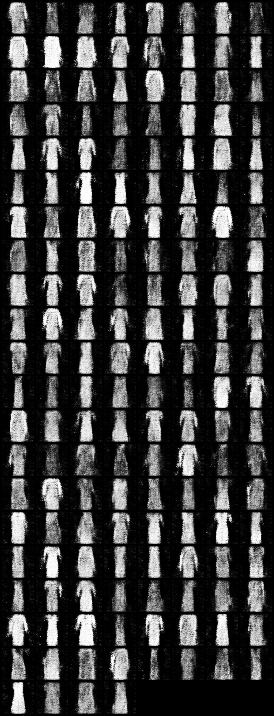

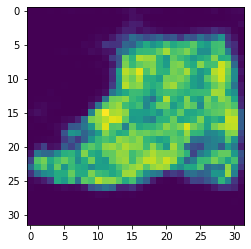

In [197]:
plt.imshow(samples[0][0].cpu().detach().numpy()) #generated sample of a shoe

# Model

Instead multiclass GAN like ConditionalGAN we will use GAN for each class when we will be learning task consisting this class. 
When the GAN is trained, we will use generator to generate "memories" of this class and pass them to the GENERATIVE REPLAY BUFFER.
This will have similar results as if we trained one big ConditionalGAN and sample from it, but it is hard to train CGAN in short time as one seperate GAN :)

# Generative Replay

In [40]:
class GenerativeReplay:
    def __init__(self, gans, samples_per_class):
        self.samples_per_class = samples_per_class # how may samples generate
        self.samples = torch.Tensor([])
        self.targets = torch.Tensor([])
        self.gans = gans

    def store_data(self, loader):
        # take data from task
        samples, targets = torch.Tensor([]), torch.Tensor([])
        for sample, target in loader:
            self.samples = torch.cat((samples, sample))
            self.targets = torch.cat((targets, target))
        # generate samples
        for task, task_gans in self.gans.items():
            for target, gan in task_gans.items():
                with torch.no_grad():
                    noise = torch.randn(self.samples_per_class, 100)
                    gen_targets = int(target) * torch.ones(self.samples_per_class)
                    gen_samples = gan.generator.cpu()(noise)
                    self.samples = torch.cat((self.samples, gen_samples))
                    self.targets = torch.cat((self.targets, gen_targets))

    def get_data(self):
        return self.samples, self.targets.to(torch.int64)

    def __len__(self):
        assert len(self.samples) == len(self.targets), f"Incosistent lengths of data tensor: {self.samples.shape}, target tensor: {self.targets.shape}!"
        return len(self.samples)

In [41]:
class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [42]:
class ConvNet(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        self.conv_layers = [nn.Conv2d(1, 16, kernel_size=3, stride=1), nn.ReLU(True),
                       nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(True),
                       nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(True),
                       nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),nn.ReLU(True)]
        self.convs = nn.Sequential(*self.conv_layers)
        self.fcs = [nn.Linear(14400, 576), nn.ReLU(True),
                   nn.Linear(576, args['num_classes'])]
        self.linears = nn.Sequential(*self.fcs)
      

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1) 
        x = self.linears(x)
        return x

# Training Agent

In [72]:
from torchvision import datasets
class Agent:
    def __init__(self, args, train_datasets, val_datasets, solver, task_name='basic_model'):
        # setup for clearML
        self.task = Task.create(project_name='CLGenerativeReplay', task_name=task_name)
        self.logger = self.task.get_logger()
        self.task.set_parameters({'lr': args['lr'], 'disc_lr':args['disc_lr'] , 'gen_lr': args['gen_lr'],
                                  'batch_size': args['bs'], 'gan_epochs' : args['gan_epochs']})
        # solver setup
        self.args = args
        self.task_num = 0
        self.solver = solver
        if torch.cuda.is_available():
            self.solver.cuda()
        self.optimizer = torch.optim.Adam(self.solver.parameters(), lr=self.args['lr'])
        self.criterion = torch.nn.CrossEntropyLoss()
        # metrics
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets
        # generative replay buffer
        self.replay_buffer = GenerativeReplay({}, samples_per_class=args['gen_samples_per_class'])
        self.current_task = 'initial'

    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}

    def train(self):
        for task, data in self.train_datasets.items():
            loader = DataLoader(data, batch_size=args['bs'], shuffle=True)
            self.current_task = task
            if torch.cuda.is_available():
                self.solver.cuda()
            # train new DCGANs for new classes in task
            gans = train_DCGAN(train, class_split[task], self.args)
            self.replay_buffer.gans[task] = gans
            self.replay_buffer.store_data(loader)

            print(f"Task {task} -- buffer stores {len(self.replay_buffer)} samples")
            samples, targets = self.replay_buffer.get_data()
            generative_dataset = TensorDataset(samples, targets)
            generative_loader = DataLoader(generative_dataset, batch_size=self.args['bs'], shuffle=True)

            for epoch in range(self.args['epochs']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(generative_loader):
                    if torch.cuda.is_available():
                        X, y = X.cuda(), y.cuda()
                    output = self.solver(X)
                    loss = self.criterion(output, y)
                    self.optimizer.zero_grad()
                    loss.backward() 
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y)
                    total += len(X)
                    if e % 50 == 0:
                        self.validate(e)
                print(f"Epoch {epoch}: Loss {epoch_loss/(e+1):.3f} Acc: {correct/total:.3f}")
                self.logger.report_scalar(title='Epoch loss', series='Train task' + self.current_task, iteration=epoch, value=epoch/(e+1))
                self.logger.report_scalar(title='Epoch accuracy', series='Train task' + self.current_task, iteration=epoch, value=correct/total)
            self.validate(epoch, end_of_epoch=True)
            self.task_num +=1


    @torch.no_grad()
    def validate(self, e=1, end_of_epoch=False):
        self.solver.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=args['bs'])
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                if torch.cuda.is_available():
                    X, y = X.cuda(), y.cuda()
                output = self.solver(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if not end_of_epoch:
                self.logger.report_scalar(title='Accuracy every 50 batches', series='Validate task' + self.current_task, iteration=int(e/50), value=correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
                self.logger.report_scalar(title='Epoch accuracy', series='Validate task' + self.current_task, iteration=e, value=correct/total)

        self.solver.train()




# Training

In [73]:
args = {
    'lr': 1.5 * 1e-3, 
    'bs': 128, 
    'epochs': 5, 
    'num_tasks': 5,
    'dataset': "FashionMNIST",
    'num_classes': 10, 
    'in_size': 32,
    'n_channels': 1,
    'hidden_size': 50,
    'disc_lr' : 0.0001,
    'gen_lr' : 0.0003,
    'gan_epochs' : 30,
    'gan_step_channels' : 16, 
    'gen_samples_per_class' : 750
    }

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [74]:
val_tasks

{'0': <torch.utils.data.dataset.Subset at 0x7f3a23f27310>,
 '1': <torch.utils.data.dataset.Subset at 0x7f3a23f27450>,
 '2': <torch.utils.data.dataset.Subset at 0x7f3a23f27490>,
 '3': <torch.utils.data.dataset.Subset at 0x7f3a23f274d0>,
 '4': <torch.utils.data.dataset.Subset at 0x7f3a23f27510>}

Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 2.0063140392303467
generator Mean Gradients : 5.287774348483455
discriminator Mean Gradients : 27.326618643448455
Mean Running Discriminator Loss : 0.33314348693857804
Mean Running Generator Loss : 0.37114227452176685
Generating and Saving Images to ./images/epoch1_generator.png



/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 2.0041840076446533
generator Mean Gradients : 4.358275360624709
discriminator Mean Gradients : 17.20121216826864
Mean Running Discriminator Loss : 0.2385973885972449
Mean Running Generator Loss : 0.43510181060496794
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 1.9546830654144287
generator Mean Gradients : 3.8584675761862575
discriminator Mean Gradients : 13.757181191345117
Mean Running Discriminator Loss : 0.19666447606703913
Mean Running Generator Loss : 0.46337236030727413
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
Epoch time duration : 1.9566259384155273
generator Mean Gradients : 3.458749124425221
discriminator Mean Gradients : 11.970573053030801
Mean Running Discriminator Loss : 0.17283808955169738
Mean Running Generator Loss : 0.48723128120949

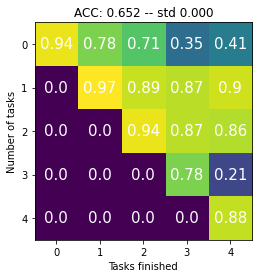

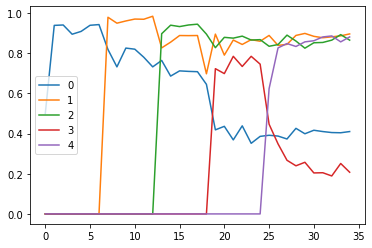

The average accuracy at the end of sequence is: 0.652
BWT:'-0.315'
FWT:'-0.140'


In [75]:
cnet =  ConvNet(args)
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

agent = Agent(args,  train_tasks, val_tasks, cnet, task_name='basic_model')

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

In [51]:
args

{'bs': 128,
 'dataset': 'FashionMNIST',
 'disc_lr': 0.0001,
 'epochs': 5,
 'gan_epochs': 30,
 'gan_step_channels': 16,
 'gen_lr': 0.0003,
 'gen_samples_per_class': 750,
 'hidden_size': 50,
 'in_size': 32,
 'lr': 0.0015,
 'n_channels': 1,
 'num_classes': 10,
 'num_tasks': 5,
 'task_names': ['0', '1', '2', '3', '4']}

# Training and evaluation

### Linear solvers

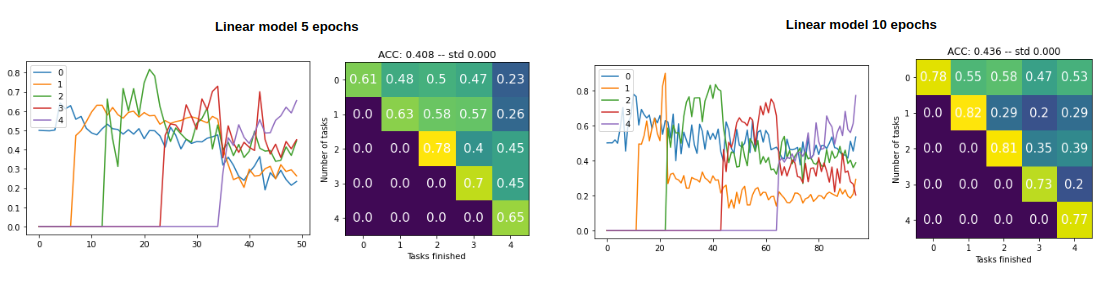

### Convolutional models

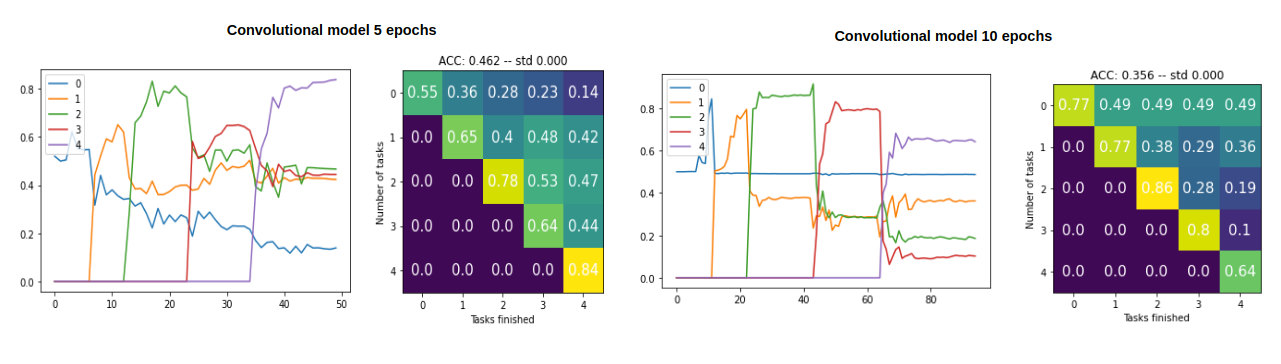

Elongating the time of learning resulted in better rembering first learned task but next tasks were fastly replaces

### Memory and computational complexity

In [5]:
from torch.profiler import profile, record_function, ProfilerActivity

In [23]:
linear_net = MLP(args).to(DEVICE)
convnet =  ConvNet(args).to(DEVICE)

In [57]:
train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
loader = DataLoader(train, batch_size=args['bs'], shuffle=True)

In [58]:
inputs = next(iter(loader))[0].to(DEVICE)

In [470]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        linear_net(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         7.76%     349.000us        98.89%       4.447ms       4.447ms       0.000us         0.00%     105.000us     105.000us             1  
                                           aten::linear         1.87%      84.000us        84.06%       3.780ms     945.000us       0.000us         0.00%      93.000us      23.250us             4  
         

In [465]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        convnet(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         5.13%     527.000us        85.23%       8.751ms       8.751ms       0.000us         0.00%       4.227ms       4.227ms             1  
                                           aten::conv2d         0.53%      54.000us        73.03%       7.498ms       1.875ms       0.000us         0.00%       2.986ms     746.500us             4  
         

In [59]:
gan_tasks['0']

In [62]:

dcgan_network = {
            "generator": {
                "name": DCGANGenerator,
                "args": {
                    "encoding_dims": 100,
                    "out_channels": 1,
                    "step_channels": args['gan_step_channels'],
                    "nonlinearity": nn.LeakyReLU(0.2),
                    "last_nonlinearity": nn.Tanh(),
                },
                "optimizer": {"name": torch.optim.Adam, "args": {"lr": args['gen_lr'], "betas": (0.5, 0.999)}},
            },
            "discriminator": {
                "name": DCGANDiscriminator,
                "args": {
                    "in_channels": 1,
                    "step_channels": args['gan_step_channels'],
                    "nonlinearity": nn.LeakyReLU(0.2),
                    "last_nonlinearity": nn.LeakyReLU(0.2),
                },
                "optimizer": {"name": torch.optim.Adam, "args": {"lr": args['disc_lr'], "betas": (0.5, 0.999)}},
            },
        }
gan_split = {str(i): classi for i, classi in enumerate( class_split['0'])}  #e.g. class_split['0'] == task classes
gan_tasks = split_dataset(train, gan_split)
gans = {}
for key, subtask in gan_tasks.items():
    loader = DataLoader(subtask, batch_size=args['bs'], shuffle=True)
    break
lsgan_losses = [LeastSquaresGeneratorLoss(), LeastSquaresDiscriminatorLoss()] 
trainer = Trainer(dcgan_network, lsgan_losses, sample_size=1, epochs=1, device=DEVICE)
trainer(loader)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
         # train network
         noise = torch.randn(args['bs'], 100).to(DEVICE)
         trainer.generator(noise)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 2.1336429119110107
generator Mean Gradients : 5.899761802736975
discriminator Mean Gradients : 33.46094981625598
Mean Running Discriminator Loss : 0.4039514185266292
Mean Running Generator Loss : 0.3792325201186728
Generating and Saving Images to ./images/epoch1_generator.png

Training of the Model is Complete
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


## Number of weights in nets

In [68]:
def count_model_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [69]:
count_model_params(linear_net)

56860

In [70]:
count_model_params(convnet)

8319418

In [71]:
count_model_params(trainer.generator)

143841

# Results

Bet model trained using generative replau scored about 65% in 5 epochs per taks see last agent output, those this method seems to be very close to how people memorize thing and can 'replay memories' that are some representation of the real object/task. We see that this method is computationaly expensive since it takes about 30 epochs for GAN to memorize  one class. In this project I also tried using convnet, they seem to be more proper for task classification image, and they may easier catch the common and incommon features between tasks.

For further imporvement I would try to adjust learning rate and number of epochs for eash training. From small experiments it seems that changing the time of training drastically change which class are forgotten more, especially in convnet example.